In [1]:
import utils 

from utils import *

/home/ubuntu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import cv2
import scipy
from keras.applications import InceptionResNetV2
from keras.callbacks import ReduceLROnPlateau

In [3]:
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline


### Load Data

In [4]:
train = pd.read_json("data/input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("data/input/test.json")


In [5]:
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
X_test_angle=test['inc_angle']

In [6]:
# sample_weights = {0:}

In [7]:
test.shape

(8424, 4)

In [8]:
test.shape[0]/8.

1053.0

### Preprocess

In [7]:


#Generate the training data
band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
band_3=(band_1+band_2)
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])


a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

X_train = np.concatenate([a[:, :, :, np.newaxis]
                  , b[:, :, :, np.newaxis]
                 , b[:, :, :, np.newaxis]], axis=-1)



In [9]:


band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
band_3=(band_1+band_2)

a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([a[:, :, :, np.newaxis]
                          , b[:, :, :, np.newaxis]
                         , c[:, :, :, np.newaxis]], axis=-1)

In [10]:
X_train = scipy.ndimage.zoom(X_train, 2, order=0)[:X_train.shape[0],:,:,:3]

In [11]:
X_test = scipy.ndimage.zoom(X_test, 2, order=0)[:X_test.shape[0],:,:,:3]

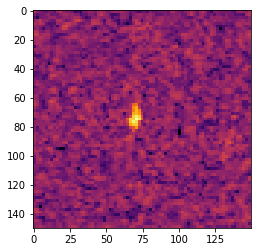

In [12]:
plt.imshow(X_train[0,:,:,2],cmap='inferno')

### Train Model 

In [13]:


batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.0,
                         rotation_range = 10)

In [15]:

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
def get_callbacks(filepath, p=5):
    es = EarlyStopping('val_loss', patience=p ,verbose=1)
    msave = ModelCheckpoint(filepath, save_best_only=True)
    lrplateu = ReduceLROnPlateau(monitor='val_loss',  patience=2, epsilon=0.01, verbose=1, factor=0.1, min_lr=1e-5)

    return [es, msave,lrplateu]


In [16]:
def getModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
#     base_model = VGG16(weights='imagenet', include_top=False, 
#                  input_shape=X_train.shape[1:], classes=1)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('conv_7b_ac').output
    

    x = Flatten()(x) #GlobalMaxPooling2D
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(input=[base_model.input, input_2], output=predictions)
    
    sgd = Adam(lr=1e-3) #SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model


In [37]:
X_train.shape[0]*0.9//64

22.0

In [17]:


#Using K-fold Cross Validation with Data Augmentation.
def trainKfold(X_train, X_angle, X_test):
    K=10
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=17).split(X_train, target_train))
    y_test_pred_log = 0
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    
    
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\n===================FOLD=',j+1)
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        Y_holdout= target_train[test_idx]
        
        #Angle
        X_angle_cv=X_angle[train_idx]
        X_angle_hold=X_angle[test_idx]

        #define file path and get callbacks
        file_path = "weights/{}_{}.hdf5".format(exp_name,j+1)
        callbacks = get_callbacks(filepath=file_path)
        gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
        
        model= getModel()
        model.fit_generator(
                gen_flow,
                steps_per_epoch=22,
                epochs=100,
                shuffle=True,
                verbose=1,
                validation_data=([X_holdout,X_angle_hold], Y_holdout),
                callbacks=callbacks)

        #Getting the Best Model
        model.load_weights(filepath=file_path)
        #Getting Training Score
        score = model.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        
        #Getting Test Score
        score = model.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        #Getting validation Score.
        pred_valid=model.predict([X_holdout,X_angle_hold])
        y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores

        temp_test=model.predict([X_test, X_test_angle])
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])
        


        #Getting Train Scores
        temp_train=model.predict([X_train, X_angle])
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

    y_test_pred_log=y_test_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    
    train_log_loss = log_loss(target_train, y_train_pred_log) 
    valid_log_loss = log_loss(target_train, y_valid_pred_log)
    
    print('\n Train Log Loss Validation= ',train_log_loss)
    print(' Valid Log Loss Validation= ',valid_log_loss)
    
    
    return y_train_pred_log, y_valid_pred_log, y_test_pred_log, train_log_loss, valid_log_loss





In [18]:
exp_name = "_10f_inceptres2"
train_preds , val_preds, test_preds, train_log_loss,valid_log_loss = trainKfold(X_train, X_angle, X_test)

('\n===================FOLD=', 1)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


Epoch 1/100
22/22 [==============================] - 227s 10s/step - loss: 1.2597 - acc: 0.5036 - val_loss: 0.9261 - val_acc: 0.4691
Epoch 2/100
22/22 [==============================] - 41s 2s/step - loss: 0.8888 - acc: 0.5025 - val_loss: 0.6936 - val_acc: 0.4753
Epoch 3/100
22/22 [==============================] - 41s 2s/step - loss: 0.9782 - acc: 0.5080 - val_loss: 0.6922 - val_acc: 0.5247
Epoch 4/100
22/22 [==============================] - 41s 2s/step - loss: 0.9077 - acc: 0.5110 - val_loss: 0.6920 - val_acc: 0.5247
Epoch 5/100
21/22 [===========================>..] - ETA: 1s - loss: 0.8747 - acc: 0.4963
Epoch 00005: reducing learning rate to 0.00010000000475.
22/22 [==============================] - 43s 2s/step - loss: 0.8774 - acc: 0.4972 - val_loss: 0.6919 - val_acc: 0.5309
Epoch 6/100
22/22 [==============================] - 41s 2s/step - loss: 0.8539 - acc: 0.5109 - val_loss: 0.6918 - val_acc: 0.5309
Epoch 7/100
21/22 [===========================>..] - ETA: 1s - loss: 0.8470 -

KeyboardInterrupt: 

In [1]:
pickle.dump(file=open("cache/{}_tmp_results.dmp".format(exp_name),"wb"), obj=[train_preds , val_preds, test_preds, train_log_loss,valid_log_loss])


NameError: name 'pickle' is not defined

In [62]:
train_preds , val_preds, test_preds, train_log_loss, valid_log_loss = pickle.load(file=open("tmp_results.dmp","rb"))


    

### TTA


In [ ]:
def make_TTA_preds(exp_name):

    K=3
    y_test_pred_log = 0
    
    

    def gen_flow_for_two_inputs_test(test_gen, X1, X2):
        genX2 = test_gen.flow(X1,X2, batch_size=8,shuffle=False)
        while True:
                X2i = genX2.next()
                yield [X2i[0], X2i[1]]

    partials = []
    
    
    for j in range(K):
        print('\n===================FOLD=',j+1)
        
        model= getModel()

        #Getting the Best Model
        model.load_weights("weights/{}_{}.hdf5".format(exp_name,j+1))
        #Getting Training Score

        
        test_gen = ImageDataGenerator(horizontal_flip = True,
                                      vertical_flip = True, 
                                      width_shift_range = 0.,  
                                      height_shift_range = 0.,      
                                      channel_shift_range=0,        
                                      zoom_range = 0.2,         
                                      rotation_range = 10)   


        preds = np.zeros((test.shape[0],1)).astype(np.float32) 

        num_aug = 5
        for i in range(num_aug):
            gen_flow_test = gen_flow_for_two_inputs_test(test_gen, X_test, X_test_angle)
            preds += model.predict_generator(gen_flow_test,steps=test.shape[0]/8, verbose=1).reshape(-1,1)


        partials.append(preds/num_aug)    
        temp_test=preds/num_aug
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])                           
                           

    y_test_pred_log=y_test_pred_log/K


    
    return y_test_pred_log, partials


    
tta_preds_3fold_baseline,partials = make_TTA_preds("_3fold_baseline")    


### Submission

In [26]:

def update_results_h5(phase, exp_name, train_id, test_id, train_preds, val_preds,test_preds, train_log_loss,valid_log_loss, LB_score=0.0):
		
		train_preds  = pd.DataFrame(data={"is_iceberg":train_preds})
		train_preds["id"]=train_id.astype(str)
		train_preds.set_index("id",inplace=True)

		
		
		val_preds  = pd.DataFrame(data={"id":train['id'],"is_iceberg":val_preds})
		val_preds["id"]=train_id.astype(str)
		val_preds.set_index("id",inplace=True)
		
		
		
		submission = pd.DataFrame()
		submission['id']=test_id
		submission['is_iceberg']=test_preds
		submission.to_csv('subm/{}.csv'.format(exp_name), index=False)

		submission['id']=test['id'].astype(str)
		submission.set_index("id",inplace=True)


		
		train_preds.to_hdf('data/results.h5',"/{}/train/{}".format(phase,exp_name))
		val_preds.to_hdf('data/results.h5',"/{}/valid/{}".format(phase,exp_name))
		submission.to_hdf('data/results.h5',"/{}/test/{}".format(phase,exp_name))



		

		store = pd.HDFStore('data/results.h5')

		store.append("/summary",pd.DataFrame(data={"phase":[phase],
																							 "exp":[exp_name],
																							 "train_log_loss":[train_log_loss],
																							 "val_log_loss":[valid_log_loss], 
																							 "LB":[LB_score] }) )  

		store.close()

In [27]:
update_results_h5("ph1", exp_name, train["id"], test["id"], 
                  train_preds, val_preds,test_preds, train_log_loss,valid_log_loss, LB_score=0.176 )

In [63]:
train_preds  = pd.DataFrame(data={"is_iceberg":train_preds})
train_preds["id"]=train['id'].astype(str)
train_preds.set_index("id",inplace=True)




In [45]:
### Submissionval_preds  = pd.DataFrame(data={"id":train['id'],"is_iceberg":val_preds})
val_preds["id"]=train['id'].astype(str)
val_preds.set_index("id",inplace=True)

In [25]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id'].astype(str)
submission['is_iceberg']= tta_preds_3fold_baseline
submission.to_csv('subm/{}.csv'.format("_3f_tta"), index=False)

submission.set_index("id",inplace=True)

In [2]:
import pandas as pd 

In [3]:
store = pd.HDFStore('data/results.h5')


In [45]:
np.corrcoef(store.select("/ph1/valid/_5fold_baseline").values.ravel(), store.select("/ph1/train/_5fold_baseline").values.ravel())

array([[ 1.        ,  0.80484443],
       [ 0.80484443,  1.        ]])

In [8]:
store.close()

In [4]:
store.keys()

['/summary',
 '/ph1/test/_3f_aug0_1',
 '/ph1/test/_3f_imgstats',
 '/ph1/test/_3f_xception',
 '/ph1/test/_3fmax_tflat',
 '/ph1/test/_3fold_1xconvs',
 '/ph1/test/_3fold_1xconvs_nobninthestart',
 '/ph1/test/_3fold_baseline',
 '/ph1/test/_5fold_baseline',
 '/ph1/test/_5fold_fcn',
 '/ph1/train/_3f_aug0_1',
 '/ph1/train/_3f_imgstats',
 '/ph1/train/_3f_xception',
 '/ph1/train/_3fmax_tflat',
 '/ph1/train/_3fold_1xconvs',
 '/ph1/train/_3fold_1xconvs_nobninthestart',
 '/ph1/train/_3fold_baseline',
 '/ph1/train/_5fold_baseline',
 '/ph1/train/_5fold_fcn',
 '/ph1/valid/_3f_aug0_1',
 '/ph1/valid/_3f_imgstats',
 '/ph1/valid/_3f_xception',
 '/ph1/valid/_3fmax_tflat',
 '/ph1/valid/_3fold_1xconvs',
 '/ph1/valid/_3fold_1xconvs_nobninthestart',
 '/ph1/valid/_3fold_baseline',
 '/ph1/valid/_5fold_baseline',
 '/ph1/valid/_5fold_fcn']

In [7]:
store.get('/ph1/test/_3fold_baseline').reset_index().to_csv("subm/_3fold_baseline.csv",index=False)

In [82]:
benchmark3cv = pd.read_csv("subm/sub_benchmark.csv")

In [84]:
benchmark3cv.set_index('id',inplace=True)

In [92]:
benchmark3cv.join(store.get("/ph1/test/_5fold_baseline"),lsuffix="_3cv").corr()

,is_iceberg_3cv,is_iceberg
is_iceberg_3cv,1.000000,0.975071
is_iceberg,0.975071,1.000000
